<div class="alert alert-block alert-warning">
<b>REQUIREMENT:</b> Before proceeding, install or update your
<b><a class="divlink" href="https://stenv.readthedocs.io/en/latest">stenv</a></b> distribution.  <b>stenv</b> is the replacement for AstroConda, which is unsupported as of February 2023.
</div>

<a id="titleFindsat"></a>
# Satellite trail detection in ACS/WFC data using acstools.findsat_mrt

This notebook provides examples of how to find and create masks for satellite trails in ACS/WFC imaging data using <a href= 'https://acstools.readthedocs.io/en/latest/findsat_mrt.html'>acstools.findsat_mrt</a>, which is based on the method described in <a href="https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr2208.pdf">ACS ISR 2022-08</a>. Many of the tools presented here should be applicable to any imaging data.

### Table of Contents:

[Introduction](#intro_ID) <br>
[Imports, Setup, and Data](#imports) <br>

[Example 1: Step-by-step guide to find trails in an FLC image](#example1) <br>
[Example 2: Quick run on an FLC image](#example2)<br>
[Example 3: Find trails in an FLC image using the WFC wrapper](#example3) <br>
[Example 4: Step-by-step guide to find trails in a DRC image](#example4) <br>
[Example 5: Find trails in a DRC image using the WFC wrapper](#example5)<br>
[Example 6: Create a new kernel for detection](#example6)<br>

### About this Notebook
**Author:** David V. Stark, ACS Instrument Team, Space Telescope Science Institute <br>
**First Published On:** 5/13/2023 <br>
**Updated On:** 5/15/2023

<a id="intro_ID"></a>
## Introduction

Despite being in orbit, HST imaging data still suffers from contamination by artificial satellites that can compromise science data unless they are identified and masked. This notebook presents examples of how to identify satellite trails in ACS/WFC data. The routine is also effective at identifying other linear features duch as <a href="https://hst-docs.stsci.edu/acsdhb/files/60243156/60243162/1/1567011208101/acs_Ch46.2.jpg">diffraction spikes</a> and <a href="https://hst-docs.stsci.edu/acsdhb/files/60243156/60243160/1/1567011424969/acs_Ch46.4.jpg">glint</a> (see <a href="https://hst-docs.stsci.edu/acsdhb/chapter-4-acs-data-processing-considerations/4-5-image-anomalies">Section 4.5 of the ACS DHB</a> for further discussion on these artifacts). 

A full description of the algorithm is provided in <a href="https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/instrument-science-reports-isrs/_documents/isr2208.pdf">ACS ISR 2022-08</a>. To briefly summarize, the Median Radon Transform (MRT) is calculated for an input image and used to identify linear signals in the data. The MRT is similar to the standard <a href="https://en.wikipedia.org/wiki/Radon_transform">Radon Transform</a> except that it calculates the median, rather than the sum, of data along all possible paths through an image. This modification makes the algorithm more robust against false signals from localized sources (e.g., stars, galaxies) but still very sensitive to persistent linear features, even well-below the background noise level. 

Additional post-processing is done to filter out spurious detections, primarily eliminating them based on trail S/N, width, and persistence across the image. These parameters, especially the maximum allowed trail width, are tuned for ACS/WFC data binned 2x2 and may be different for images from other instruments. Once the final set of trails is identified and characterized, a mask can be created. The routine provides numerous ways of visualizing the results, as will be demonstrated below.

The following examples illustrate how to use `acstools.findsat_mrt` to identify satellite trails and then create masks for them. Examples 1 and 4 go through the analysis step by step, including how to preprocess data and run individual routines inside `findsat_mrt`. Examples 2, 3, and 5 demonstrate how to automate many of these steps. Our demonstrations stop at the creation of the masks. We leave it to the user to decide the best way to apply the masks to their own analysis.

<a id="imports"></a>
## Imports, setup, and data

It is recommended that you use the latest <a href="https://github.com/spacetelescope/stenv">stenv</a> python environment when using this notebook. In particular, you <b>must</b> use acstools v3.6.0 or greater in order to run this notebook. You can check you version with

`conda list acstools`

and update if necessary with

`conda update acstools`

Set your working directory and import the needed packages with the following

In [1]:
# Import modules and setup
import matplotlib.pyplot as plt
import numpy as np
from astroquery.mast import Observations
from astropy.io import fits
from astropy.nddata import bitmask, block_reduce, block_replicate
from acstools.findsat_mrt import TrailFinder, WfcWrapper
import os 
from acstools.utils_findsat_mrt import create_mrt_line_kernel
import shutil

In [2]:
# Check your own working directory
print('Current working directory is {}'.format(os.getcwd()))
# Define working directory if needed
# os.chdir('Insert your working directory here')

Current working directory is /home/runner/work/hst_notebooks/hst_notebooks/notebooks/ACS/acs_findsat_mrt


In [3]:
# These are optional configurations
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.serif'] = "Georgia"
plt.rcParams['font.family'] = "serif"

Download the example data needed and place it in the working directory that you defined above. Examples 1-3 use  <a href="https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HST/product/jc8m32j5q_flc.fits">jc8m32j5q_flc.fits</a>, while examples 4-5 use <a href="https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:HST/product/hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits">hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits</a>.

In [4]:
# Download data files
obs_table = Observations.query_criteria(proposal_id=13498, obs_id='JC8M32010')

dl_table = Observations.download_products(obs_table['obsid'], 
                                          dataURI=['mast:HST/product/hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits',
                                                   'mast:HST/product/jc8m32j5q_flc.fits'])
for row in dl_table:
    oldfname = row['Local Path']
    newfname = os.path.basename(oldfname)
    os.rename(oldfname, newfname)
    
shutil.rmtree('mastDownload')

<a id="example1"></a>

## Example 1: Finding trails in an FLC image

FLC images are individual exposures processed by the CALACS pipeline. The data contain two chips, but we only analyze one here. 

We start by reading in an image and doing some pre-processing to remove bad pixels, subtract a median background, and make the image a bit smaller (to speed up the calculation of the MRT).

In [5]:
# Read in the image files and header information
image_file = 'jc8m32j5q_flc.fits'
ext = 4  # ACS image data are in extensions 1 or 4, we'll just use 4 for now (chip 1)
with fits.open(image_file) as h:
    image = h[ext].data  # image data
    dq = h[ext+2].data  # data quality bitmasks

    header = h[0].header  # primary header
    image_header = h[1].header  # image header

Below, we make a mask for bad pixels. We're ignoring cosmic rays here because routines to make them often partially (but not fully) mask trails. By default, any masked pixels are set to `NaN`.

In [6]:
mask = bitmask.bitfield_to_boolean_mask(dq, ignore_flags=[4096, 8192, 16384])
image[mask] = np.nan

Below we subtract Subtract the background from the image. Here we just do a simple median.

In [7]:
image = image - np.nanmedian(image)

The MRT is computationally demanding and WFC images are big. To help things a bit, let's rebin the images.

In [8]:
binsize = 2  # adjust this as needed
image_rebin = block_reduce(image, binsize, func=np.nansum)

We now set up `TrailFinder`. Many of the parameters in the call below are optional (and set to their current values by default) but we show them to illustrate the setup. Of note is that I'm explicitly defining the image header keys to save. These can be useful later when analyzing trail population properties. The keywords being saved here were chosen to ensure we know the original exposure ippsoot and which chip was analyzed. Additional keywords are saved that store information about the orientation of the telescope when the image was taken. In principle, the user can save any header keywords they like. We have also set `plot=False` in this example, so we can demonstrate how to manually create plots. Setting `plot=True` will automatically generate plots after specific processes are finished. Be aware that not all possible keyword parameters are defined below. See the <a href="https://acstools.readthedocs.io/en/latest/api/acstools.findsat_mrt.TrailFinder.html#acstools.findsat_mrt.TrailFinder">documentation</a> for complete information.

In [9]:
# Now we can set up TrailFinder
s = TrailFinder(image=image_rebin,
                header=header,
                image_header=image_header,
                save_image_header_keys=['ROOTNAME', 'CCDCHIP', 'CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2',
                                        'ORIENTAT', 'RA_APER', 'DEC_APER', 'PA_APER'],
                processes=8,
                plot=False,
                threshold=5,
                max_width=75,  
                check_persistence=True,
                min_persistence=0.5,
                output_root='example1')

Before we actually run anything, let's plot the image we are analyzing. You should see two satellite trails in this example.

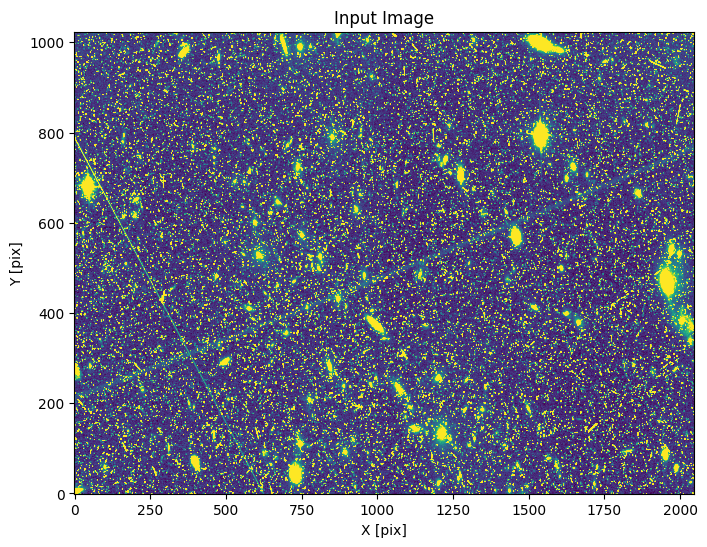

In [10]:
s.plot_image()

If you're having trouble seeing the trails, you can adjust the scale keyword (the min and max values to show given as multiples of the image standard deviation)

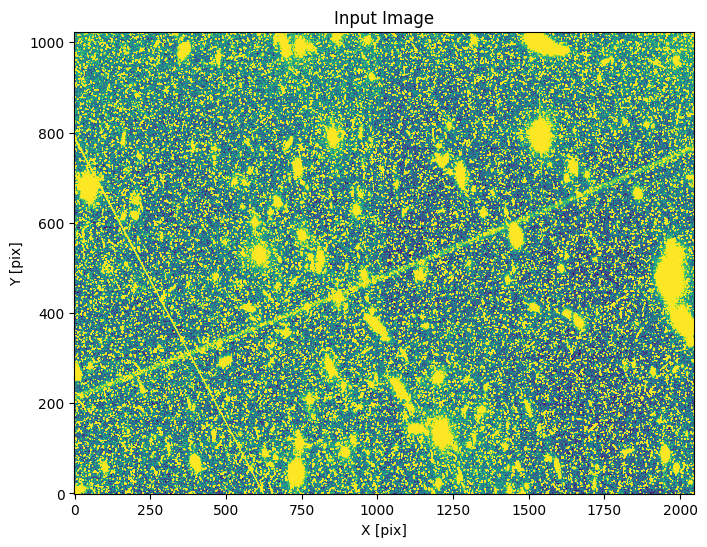

In [11]:
s.plot_image(scale=[-1, 1])

Next we run the Median Radon Transform. This step can take some time depending on the image size and number of processes being used. This tutorial assumes you can run 8 processes at the same time, but adjust as needed. If you're not sure how many processes you can run, you can see how many CPU cores are available and adjust based on that.

In [12]:
os.cpu_count()

2

In [13]:
s.processes = 8  # adjust this if necessary
s.run_mrt()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 2 processes


Now we will plot the MRT. You may be able to spot the signals from the satellite trails as two somewhat wide point-like sources.

<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

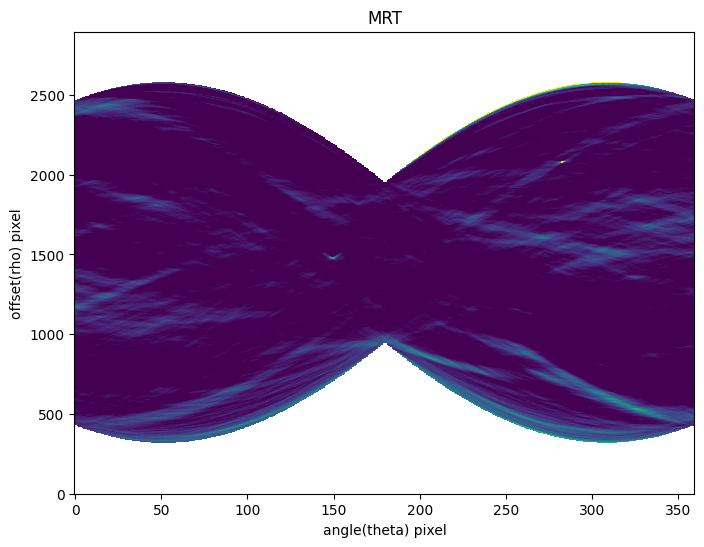

In [14]:
s.plot_mrt()

Note that the x axis in in pixels, not degrees or radians. The `theta` array ranges from 0 to 180 with a spacing of 0.5 degrees, hence 360 pixels.

We next run the source finder on the MRT. You can create your own detection kernels, or use the defaults provided (see [Example 6](#example6) for how to create detection kernels). Depending on the settings, this can pick up a lot more than the actual trails we're interested in. There are additional steps we'll take later to filter these false detections out. The ones we found and their location on the MRT are shown below.

The `threshold` in this case refers to the signal-to-noise ratio of a feature found in the MRT. The default is 5.

INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:{no} sources found using kernel: 2
INFO:findsat_mrt:2 sources found using kernel
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:{no} sources found using kernel: 4
INFO:findsat_mrt:4 sources found using kernel
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:{no} sources found using kernel: 8
INFO:findsat_mrt:8 sources found using kernel
INFO:findsat_mrt:Removing duplicate sources
INFO:findsat_mrt:8 final sources found


<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

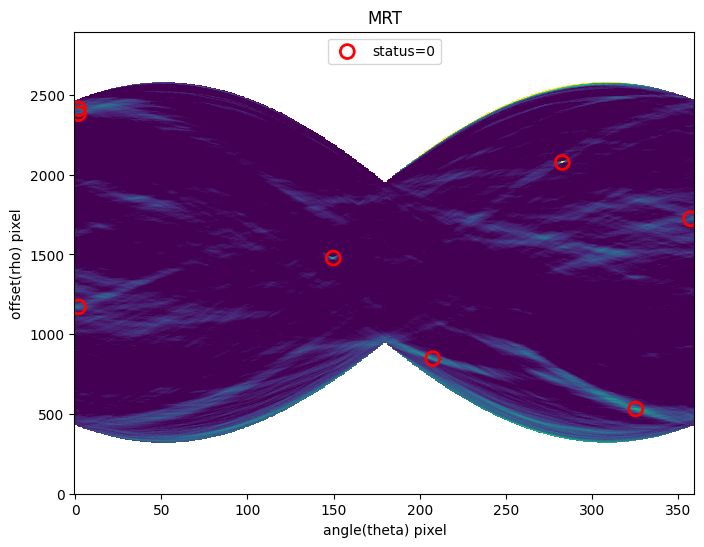

In [15]:
s.threshold = 5  # detection threshold
s.find_mrt_sources()  # finds the sources
s.plot_mrt(show_sources=True)  # overplots the sources on top of the MRT

We filter the sources further based on a reassessment of their S/N, width, and persistence. The default parameters (namely width) have been chosen for ACS data binned by 2 pixels in each direction. It's possible different defaults will be better for different imaging data.

In [16]:
# Parameters that affect how the filtering works
s.threshold = 5
s.max_width = 75
s.check_persistence = True
s.min_persistence = 0.5

# now filter
s.filter_sources()

# note: some extra columns have been added to the source list
s.source_list

INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True
INFO:findsat_mrt:Min persistence: 0.5
INFO:utils_findsat_mrt:amplitude of feature: 24.781228782083765
baseline noise: 1.1392404204749675
snr of feature = 20.752413570220828
INFO:utils_findsat_mrt:width of feature = 27.93697135868217
INFO:utils_findsat_mrt:breaking into 21.0 sections for persistence check
Section size for persistence check: 100
INFO:utils_findsat_mrt:Checking persistence, step 1 of 21
INFO:utils_findsat_mrt:amplitude of feature: 26.777939266096766
baseline noise: 5.266821168373299
snr of feature = 4.084269697041442
INFO:utils_findsat_mrt:width of feature = 26.912252404115833
INFO:utils_findsat_mrt:Chunk SNR, width, mean: 4.084269697041442, 26.912252404115833, 255.94771205201673
INFO:utils_findsat_mrt:Checking persistence, step 2 of 21
INFO:utils_findsat_mrt:amplitude of feature: 36.861090994800406
baseline noise: 4.031873465370953
snr of feature = 8.142422576351612
INF

<QTable length=8>
  id      xcentroid      ...        snr            persistence    
int64      float64       ...      float64            float64      
----- ------------------ ... ------------------ ------------------
    1  149.8247532736418 ... 20.752413570220828 0.9523809523809523
    2  282.7960369376785 ...  85.01702611978213                1.0
    3  1.892655399843995 ...  4.674521448735768                0.0
    6  1.890194693540622 ... 5.6117443647207335                0.0
    7 325.42673789644846 ...  9.671213247031142                0.0
    8 207.55564520164214 ...  8.356783560003482                0.0
   11 357.19878476679287 ...  3.055659576674491                0.0
   13 1.9268017945417673 ...  3.454152068653329                0.0

Several columns have been added to the source list that characterize the observed streak. Also, the `status` array has values of 0, 1, and 2 now (it just had 0 before). Those with `status=2` are sources that passed all filtering stages (checks for SNR and width, then persistence). Those with `status=1` are sources that passed the first filtering stage (checks for SNR and width), but not the second (persistence check). And `status=0` are sources that did not pass the filtering steps.

The `plot_mrt` command will overplot the different statuses

<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

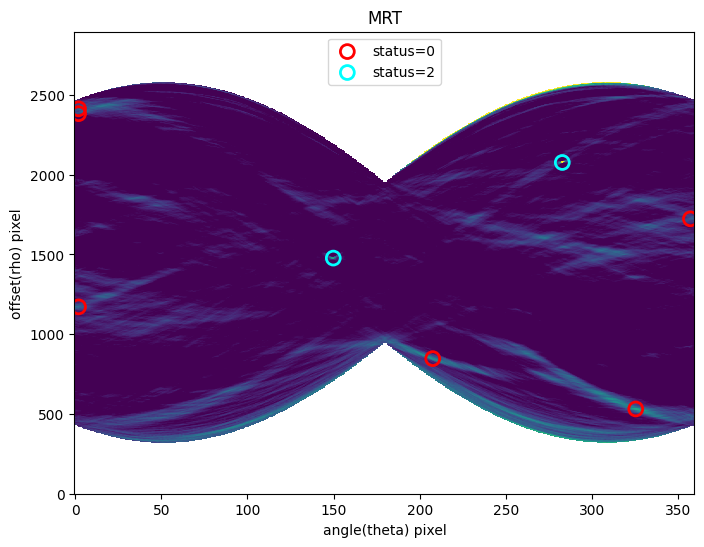

In [17]:
s.plot_mrt(show_sources=True)

Now we can make the mask itself. By default it only uses sources in the MRT with `status=2`. We make two types of masks, one a simple boolean mask, and one a segementation mask where pixels corresponding to each streak are assigned the ID number. We create these below.

In [18]:
# make the mask
s.mask_include_status = [2]
s.make_mask()

<Axes: title={'center': 'Segmentation Mask'}>

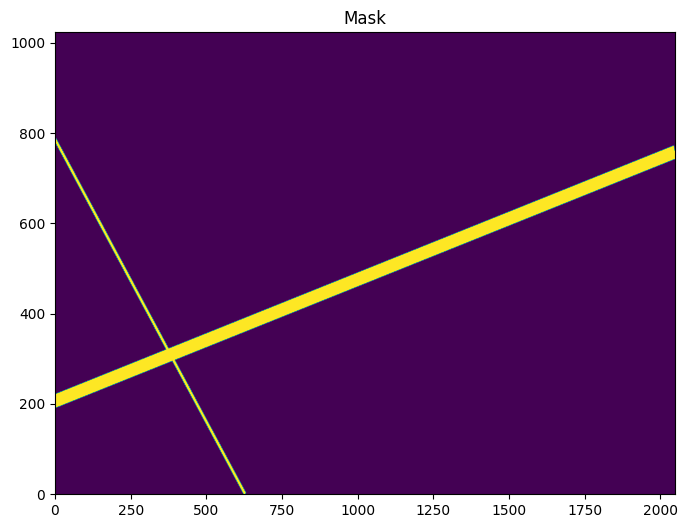

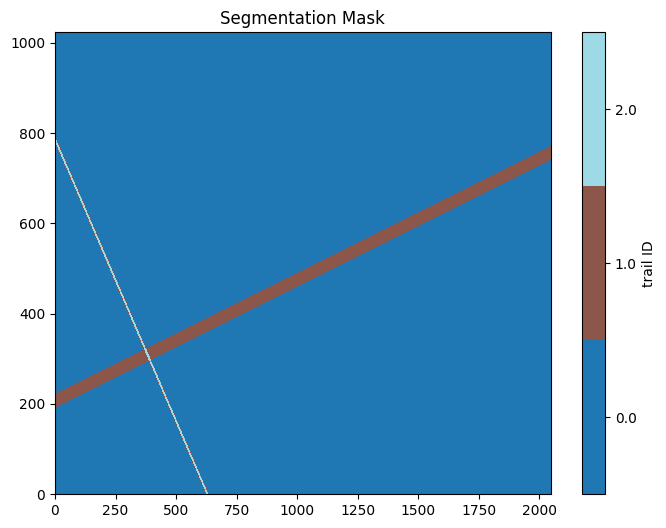

In [19]:
# plot the mask and segmentation map
s.plot_mask()
s.plot_segment()

We can also overlay the mask on top of the image to make sure it makes sense.

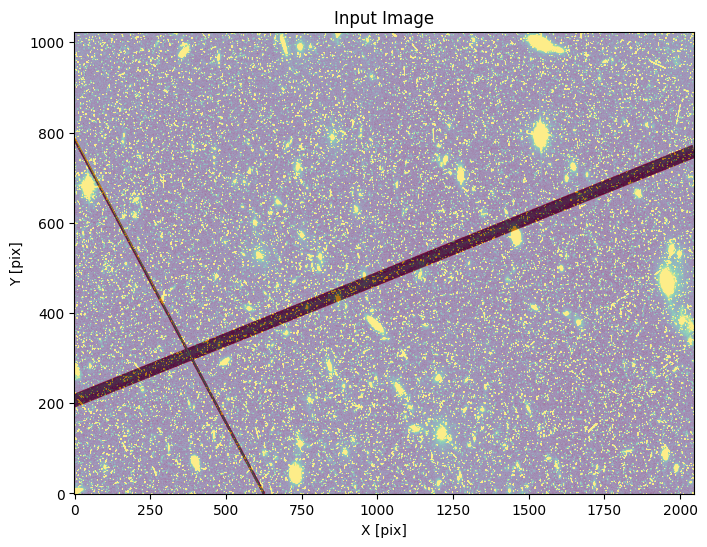

In [20]:
s.plot_image(overlay_mask=True)

We can save the results now. You have the optional of saving the catalog, mask, MRT, and a diagnostic image that shows the results. In this example we'll just save everything.

In [21]:
# define what to save
s.save_mask = True
s.save_mrt = True
s.save_catalog = True
s.save_diagnostic = True

s.save_output()

INFO:findsat_mrt:Wrote MRT to ./example1_mrt.fits
INFO:findsat_mrt:Wrote mask to ./example1_mask.fits
INFO:findsat_mrt:Wrote diagnostic plot to ./example1_diagnostic.png
INFO:findsat_mrt:wrote catalog ./example1_catalog.fits


Keep in mind that the mask we have created is applicable to the rebinned image. To convert it into a mask that can be applied to the original unbinned image, we need to resample it using the `block_replicate` function. The rescaled mask is plotted below. Note the difference in image size, but the mask pattern remains the same.

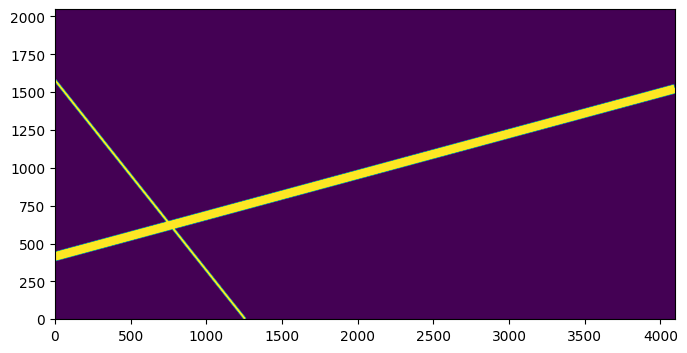

In [22]:
full_mask = block_replicate(s.mask, binsize, conserve_sum=False)
fig, ax = plt.subplots()
ax.imshow(full_mask, origin='lower')

## <a id="example2"></a>
## Example 2: Quick run of TrailFinder on an flc image

Example 1 thoroughly demonstrated the steps to read in an FLC file, pre-process it, and identify trails. This example demonstrates how one can run many of the steps simultaneously once a file is read in an all parameters set. 

First, we read in and preprocess the data file exactly as before.

In [23]:
# Read in the image files and header information
image_file = 'jc8m32j5q_flc.fits'
ext = 4  # ACS image data are in extensions 1 or 4, we'll just use 1 for now
with fits.open(image_file) as h:
    image = h[ext].data  # image data
    dq = h[ext+2].data  # data quality bitmasks
    
    header = h[0].header  # primary header
    image_header = h[1].header  # image header

# make a mask for bad pixels.
mask = bitmask.bitfield_to_boolean_mask(dq, ignore_flags=[4096, 8192, 16384])
image[mask] = np.nan

# Subtract the background from the image.
image = image - np.nanmedian(image)

# Rebin the image to speed up calculation
image_rebin = block_reduce(image, 2, func=np.nansum)
print(image)

[[ 5.3688492e+01  7.7842072e+01  8.2069962e+01 ... -3.5500183e+00
   6.0038452e+00  2.1702469e+01]
 [ 1.1057211e+02  1.1134854e+02  8.5704437e+01 ...  1.4351349e+01
  -6.9071655e+00  2.6282501e+00]
 [ 1.2605432e+02  8.3174591e+01  1.2411203e+02 ...  5.4317114e+02
   1.4528281e+03  1.2523743e+01]
 ...
 [-7.8663788e+00  1.1875504e+01 -1.3893051e+01 ...  3.0214722e+01
   9.3101196e+00 -1.3999176e+01]
 [-8.7981873e+00 -1.8275146e+00  2.6314880e+01 ...  1.9167786e+01
  -9.4055176e-02 -6.7887421e+00]
 [           nan            nan            nan ...            nan
             nan            nan]]


And initialize trail finder as before

In [24]:
s2 = TrailFinder(image=image_rebin,
                 header=header,
                 image_header=image_header,
                 save_image_header_keys=['ROOTNAME', 'CCDCHIP', 'CRPIX1', 'CRPIX2', 'CRVAL1', 'CRVAL2',
                                         'ORIENTAT', 'RA_APER', 'DEC_APER', 'PA_APER'],
                 processes=8,
                 plot=False,
                 threshold=5,
                 max_width=75,  
                 check_persistence=True,
                 min_persistence=0.5,
                 output_root='example2')

If you're feeling ok about the setup, run all the subsequent steps together with the `run_all` command (this calculates the MRT, finds MRT sources, filters the sources, and saves the output)

In [25]:
s2.run_all()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 2 processes
INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:{no} sources found using kernel: 2
INFO:findsat_mrt:2 sources found using kernel
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:{no} sources found using kernel: 4
INFO:findsat_mrt:4 sources found using kernel
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:{no} sources found using kernel: 8
INFO:findsat_mrt:8 sources found using kernel
INFO:findsat_mrt:Removing duplicate sources
INFO:findsat_mrt:8 final sources found
INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persiste

If we plot the mask, it should look identical to the one in the previous example.

<Axes: title={'center': 'Mask'}>

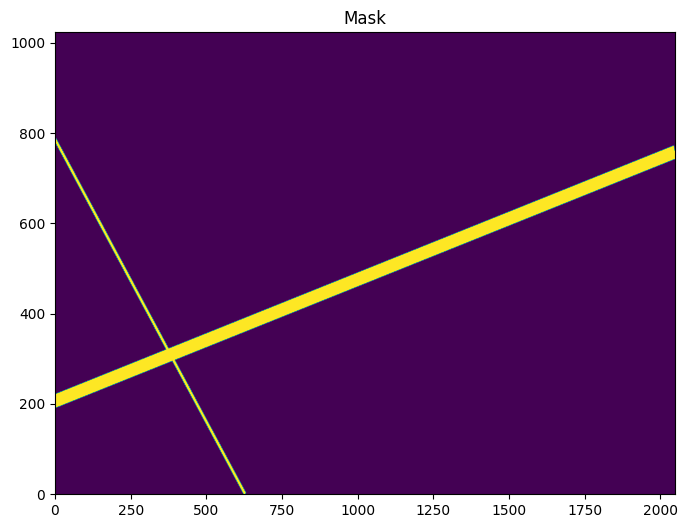

In [26]:
s2.plot_mask()

## <a id="example3"></a>
## Example 3: find trails in an FLC image using the WFC wrapper

The approaches shown in examples 1 and 2 can be useful for imaging data from any telescope, not just ACS/WFC data. However, for ACS/WFC data, we provide a convenience wrapper that performs even more of the steps all together, including reading the image and pre-processing it.

The `WfcWrapper` class has the same properties as the TrailFinder class, but with a few additional keywords. It also contains the additional routines that read the image, rebin, mask, and subtract the background. By default, these will be run automatically when WfcWrapper is initialized, although this can be turned off. In most cases, you probably will only need to adjust the `binsize` keyword. The specific value of `binsize` is up to the user. Larger values speed up the MRT calculation, but keep in mind that the parameters to filter out spurious trails (e.g., `max_width`) are tuned to WFC data binned 2x2. A user may want to start with a larger value for `binsize` and reduce it once they get a sense for the computation time.

In [27]:
w = WfcWrapper('jc8m32j5q_flc.fits', binsize=2, extension=4, processes=8, output_root='example3')

INFO:findsat_mrt:image type is flc
INFO:findsat_mrt:masking bad pixels
INFO:findsat_mrt:Subtracting median background
INFO:findsat_mrt:Rebinning the data by 2


We can plot the image to see that it looks like the one from the last example after preprocessing.

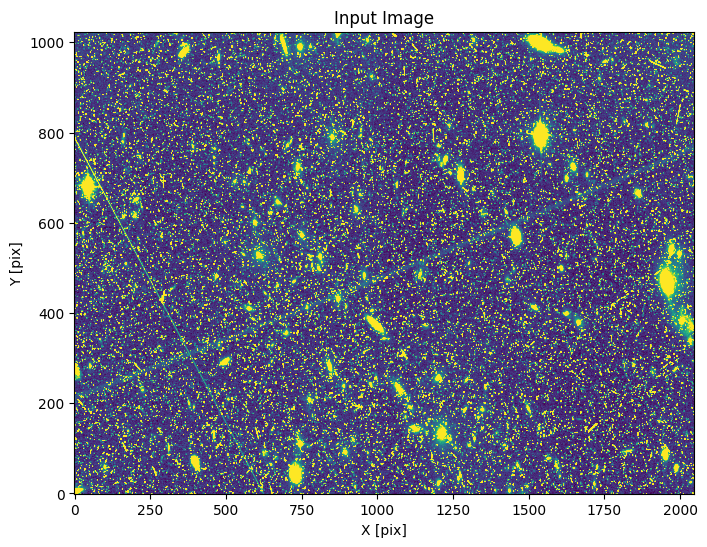

In [28]:
w.plot_image()

From here, everything is the same as the last example:

In [29]:
w.run_mrt()
w.find_mrt_sources()
w.filter_sources()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 2 processes
INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:{no} sources found using kernel: 2
INFO:findsat_mrt:2 sources found using kernel
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:{no} sources found using kernel: 4
INFO:findsat_mrt:4 sources found using kernel
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:{no} sources found using kernel: 8
INFO:findsat_mrt:8 sources found using kernel
INFO:findsat_mrt:Removing duplicate sources
INFO:findsat_mrt:8 final sources found
INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persiste

<QTable length=8>
  id      xcentroid      ...        snr            persistence    
int64      float64       ...      float64            float64      
----- ------------------ ... ------------------ ------------------
    1  149.8247532736418 ... 20.752413570220828 0.9523809523809523
    2  282.7960369376785 ...  85.01702611978213                1.0
    3  1.892655399843995 ...  4.674521448735768                0.0
    6  1.890194693540622 ... 5.6117443647207335                0.0
    7 325.42673789644846 ...  9.671213247031142                0.0
    8 207.55564520164214 ...  8.356783560003482                0.0
   11 357.19878476679287 ...  3.055659576674491                0.0
   13 1.9268017945417673 ...  3.454152068653329                0.0

Below is the resulting MRT and sources

<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

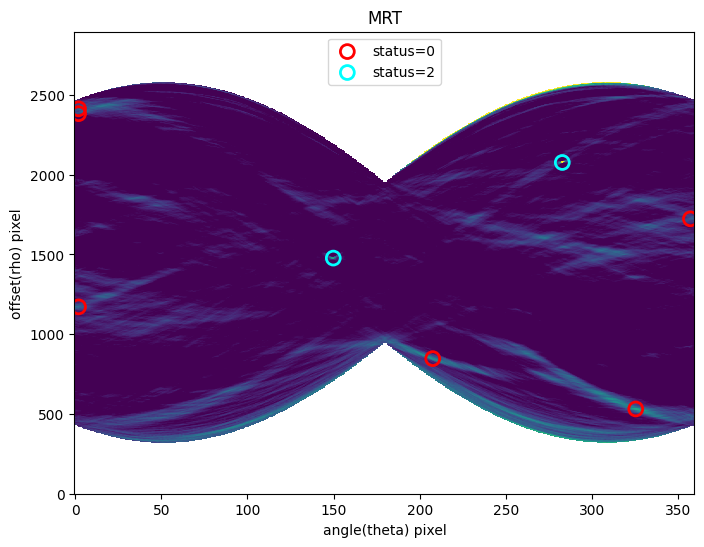

In [30]:
w.plot_mrt(show_sources=True)

Lastly, we generate the mask

<Axes: title={'center': 'Mask'}>

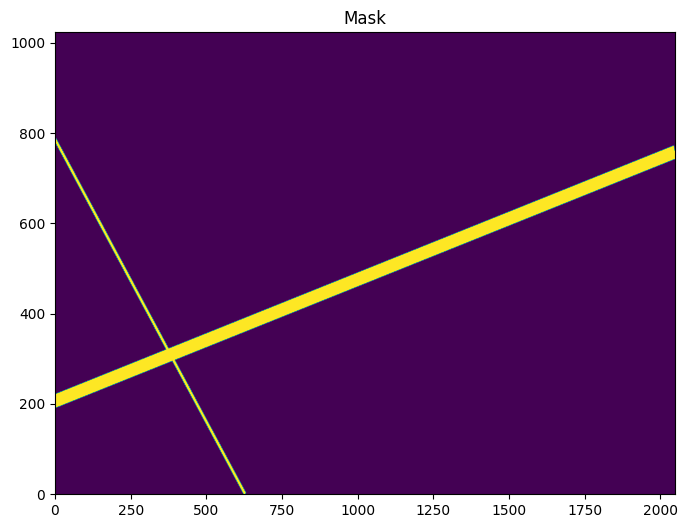

In [31]:
w.make_mask()
w.plot_mask()

If you're really feeling very confident, you can run everything in a single line by setting `execute=True`.

In [32]:
w = WfcWrapper('jc8m32j5q_flc.fits', binsize=2, extension=4, output_root='example3', processes=8,
               execute=True)

INFO:findsat_mrt:image type is flc
INFO:findsat_mrt:masking bad pixels
INFO:findsat_mrt:Subtracting median background
INFO:findsat_mrt:Rebinning the data by 2
INFO:findsat_mrt:Running the trailfinding pipeline
INFO:utils_findsat_mrt:Calculating median Radon Transform with 2 processes
INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:{no} sources found using kernel: 2
INFO:findsat_mrt:2 sources found using kernel
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:{no} sources found using kernel: 4
INFO:findsat_mrt:4 sources found using kernel
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:{no} sources found using kernel: 8
INFO:findsat

We'll plot the image and mask together to check that everything looks ok

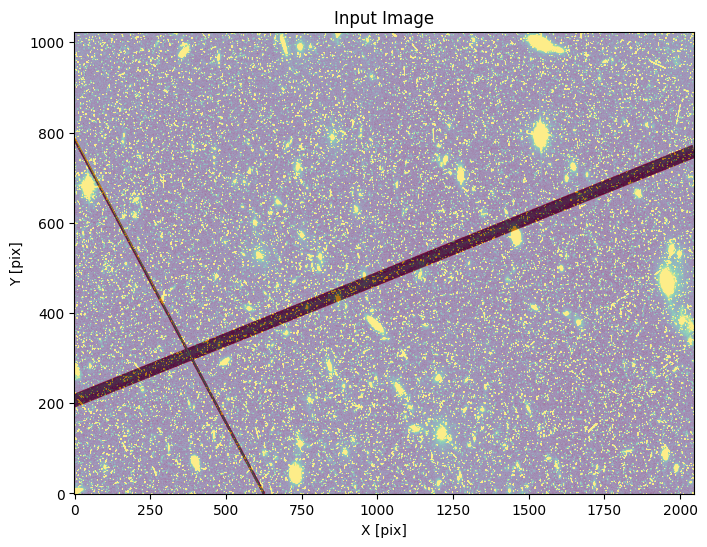

In [33]:
w.plot_image(overlay_mask=True)

<a id="example4"></a>
## Example 4: Finding trails in a DRC image

Applying `TrailFinder` to a DRC image (that shows both chips together) can boost sensitivity by increasing the number of pixels over which we search for trails. The DRC files also remove the distortion in the original FLC files (though this does not appear to create signficant curvature to most trails). 

Here, we demonstrate the steps that go into preparing a DRC image to be analyzed. The subsequent example will illustrate how to do all of this in a single line.

There are no DQ arrays for the DRC files, so we ignore the pre-processing steps that incorporated those.

In [34]:
# Read in the image files and header information
image_file = 'hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits'
ext = 1
with fits.open(image_file) as h:
    image = h[ext].data  # image data
    wht = h[ext+1].data
    image = image*wht  # wht is effective exposure time, so this turns it into counts
    
    header = h[0].header  # primary header
    image_header = h[1].header  # image header

In [35]:
# Flag anything with wht == 0 as bad
image[wht == 0] = np.nan

# Subtract the background from the image. 
median = np.nanmedian(image)
image = image - np.nanmedian(image)

In [36]:
# Let's rebin the images
binsize = 2
image_rebin = block_reduce(image, binsize, func=np.nansum)

Setting up `TrailFinder` is essentially the same as earlier examples at this point. We'll use the default settings. In fact, about all the steps from here on out are the same.

In [37]:
s4 = TrailFinder(image=image_rebin, processes=8, output_root='example4')

We can do a quick plot of our image to make sure things look ok

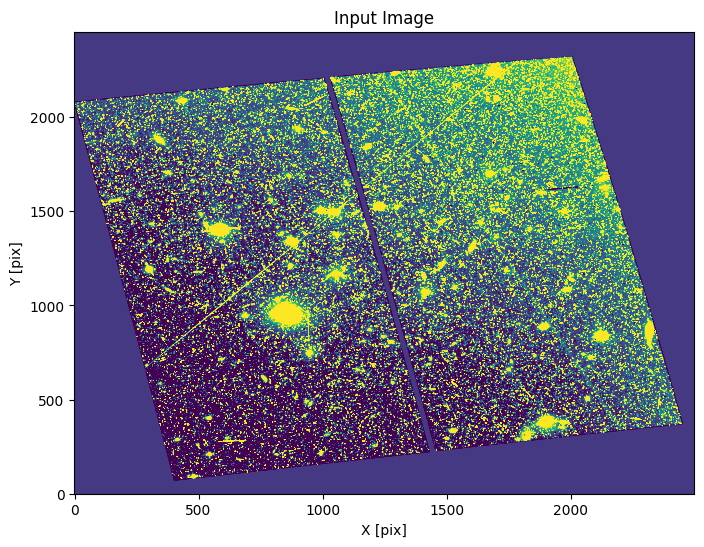

In [38]:
s4.plot_image()

Now run the MRT calculation and plot the results

INFO:utils_findsat_mrt:Calculating median Radon Transform with 2 processes


<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

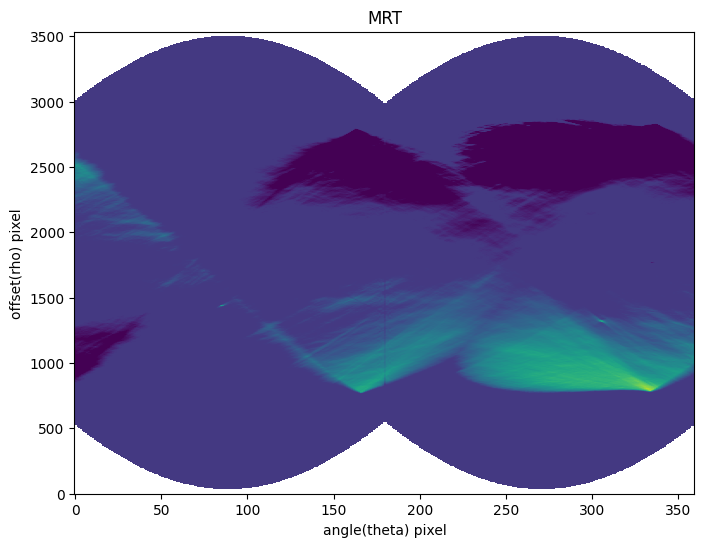

In [39]:
s4.run_mrt()
s4.plot_mrt(scale=[-1, 5])  # adjusted scale manually due to varying background in image

This example has a clear gradient in the background due to the cluster. This causes some large scale variation in the RT, but you can see the "point source" signals from the satellite trails around `x,y = (90,700)` and `x,y = (300,700)`. This is a case where we may have wanted to explore some different background subtraction methods, but we'll proceed with the simpler approach here. Now we'll try to pull the sources out.

In [40]:
s4.find_mrt_sources()

INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width15.fits
/opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/photutils/detection/starfinder.py:326: RuntimeWarning: invalid value encountered in divide
  return moments / self.moments[:, 0, 0][:, np.newaxis, np.newaxis]
/opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/photutils/detection/starfinder.py:317: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(self.flux)
INFO:findsat_mrt:{no} sources found using kernel: 96
INFO:findsat_mrt:50 sources found using kernel
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width7.fits
/opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/photutils/detection/starfinder.py:326: RuntimeWarning: invalid value encountered in divide
  ret

<QTable length=124>
  id      xcentroid      ...                endpoints                 status
int64      float64       ...               float64[2,2]               int64 
----- ------------------ ... ---------------------------------------- ------
    1  166.2862993409726 ...                 0.0 .. 2366.972780913128      0
    2  333.6189234566353 ... 1961.4955356693758 .. 160.63456781601417      0
    3 175.61873493058098 ...                0.0 .. 2175.1917522137305      0
    4 154.43223251846837 ...                 0.0 .. 2421.564062178571      0
    5  345.6329497315592 ...                1980.4159520489611 .. 0.0      0
    6 177.90318457569467 ...                0.0 .. 2119.0215363144134      0
    8  146.5801431744104 ...                            0.0 .. 2454.0      0
   10 141.26007158904315 ...                            0.0 .. 2454.0      0
   11 356.47498869382673 ...                1977.8953511636514 .. 0.0      0
   12 139.06638111584917 ...                            0.0 .. 2454.0      0
  ...                ... ...                                      ...    ...
  281  232.2440550316445 ...                -0.0 .. 809.6986521429853      0
  284 236.18309066881307 ...                -0.0 .. 726.0928864054149      0
  285  74.53527101425627 ...              144.6373154074782 .. 2454.0      0
  288  60.91845441305772 ...              418.0996040411716 .. 2454.0      0
  289 244.18588459444805 ...                -0.0 .. 537.7432473956599      0
  294 26.385381629418383 ...             1149.5273022343433 .. 2454.0      0
  297  19.10561753708832 ...             1258.2216946636972 .. 2454.0      0
  305  37.61792491931478 ...             1194.6695696691568 .. 2454.0      0
  307  12.46261610511652 ...              1472.646385273383 .. 2454.0      0
  312  3.813456036602853 ...              1640.175509855154 .. 2454.0      0

And below we plot the MRT with the sources overlaid

<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

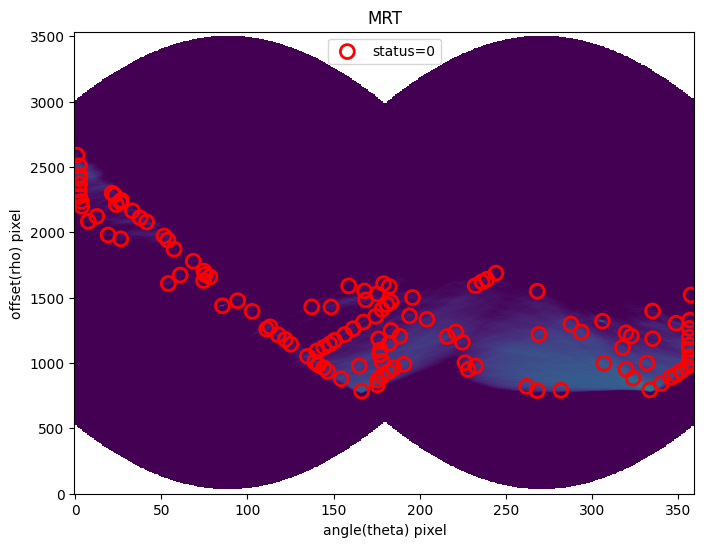

In [41]:
s4.plot_mrt(show_sources=True)

It's clearly shredding those large-scale features quite a bit, but we'll try to filter these out.

In [42]:
s4.filter_sources()

INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persistence: True
INFO:findsat_mrt:Min persistence: 0.5
INFO:utils_findsat_mrt:amplitude of feature: 15.843671281575414
baseline noise: 1.6039306382886833
snr of feature = 8.878027704788934
INFO:utils_findsat_mrt:width of feature = 144.60656477445218
INFO:utils_findsat_mrt:amplitude of feature: 25.840161725385833
baseline noise: 2.1006955757774333
snr of feature = 11.300764576905824
INFO:utils_findsat_mrt:width of feature = 145.28543228675338
INFO:utils_findsat_mrt:amplitude of feature: 12.068245289921927
baseline noise: 1.2813319780444006
snr of feature = 8.418515651455738
INFO:utils_findsat_mrt:width of feature = 184.07049037041452
INFO:utils_findsat_mrt:amplitude of feature: 11.22747947602591
baseline noise: 1.256247259380412
snr of feature = 7.937316592884241
INFO:utils_findsat_mrt:width of feature = 133.09457852686353
INFO:utils_findsat_mrt:amplitude of feature: 10.81701920708718
baseline noise: 1

<QTable length=124>
  id      xcentroid      ...        snr             persistence    
int64      float64       ...      float64             float64      
----- ------------------ ... ------------------ -------------------
    1  166.2862993409726 ...  8.878027704788934                 0.0
    2  333.6189234566353 ... 11.300764576905824                 0.0
    3 175.61873493058098 ...  8.418515651455738                 0.0
    4 154.43223251846837 ...  7.937316592884241                 0.0
    5  345.6329497315592 ...  5.449463999499764                 0.0
    6 177.90318457569467 ...  11.66102413739951                 0.0
    8  146.5801431744104 ... 12.851150856013861                 0.0
   10 141.26007158904315 ...  9.635854110553302                 0.0
   11 356.47498869382673 ...  7.139105755634444                 0.0
   12 139.06638111584917 ... 14.519597948258696                 0.0
  ...                ... ...                ...                 ...
  281  232.2440550316445 ...  4.872609321920729                 0.0
  284 236.18309066881307 ...  4.171602873544026                 0.0
  285  74.53527101425627 ...                inf 0.06666666666666667
  288  60.91845441305772 ...                inf 0.07142857142857142
  289 244.18588459444805 ... 1.5602569900986665                 0.0
  294 26.385381629418383 ...  22.69001305777236                0.04
  297  19.10561753708832 ... 21.182024512481426 0.16666666666666666
  305  37.61792491931478 ...   7531.59095455124                 0.0
  307  12.46261610511652 ...  8.045677878663424                 0.0
  312  3.813456036602853 ...  7.262243001129494                 0.0

Let's re-plot the MRT with sources to see what made it through

<Axes: title={'center': 'MRT'}, xlabel='angle(theta) pixel', ylabel='offset(rho) pixel'>

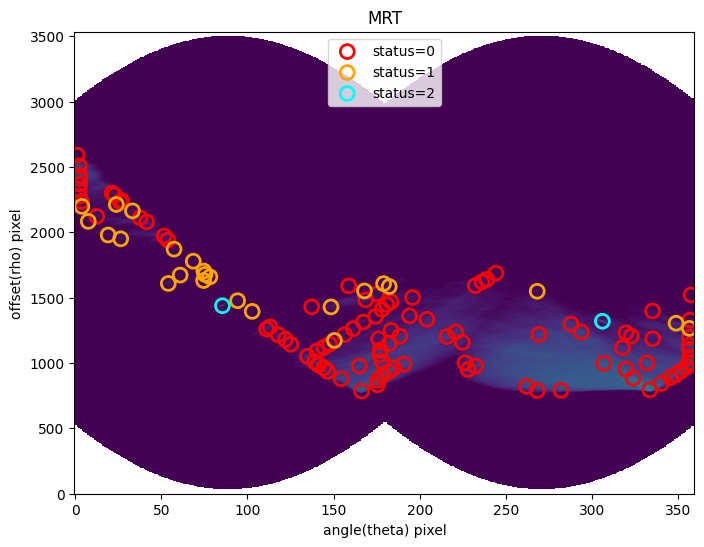

In [43]:
s4.plot_mrt(show_sources=True)

That seems to have worked! Let's make the map to confirm

<Axes: title={'center': 'Segmentation Mask'}>

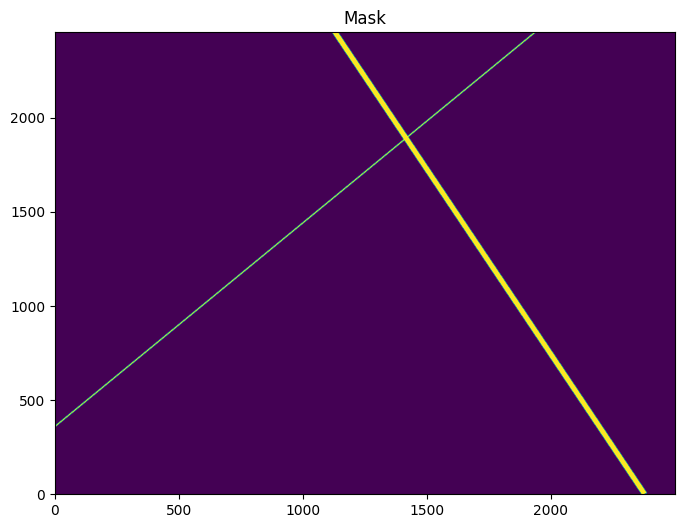

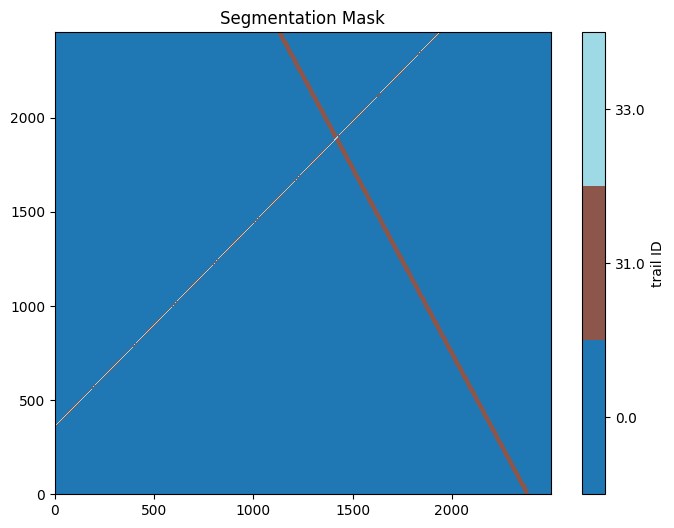

In [44]:
s4.make_mask()
s4.plot_mask()
s4.plot_segment()

Let's make a version plotting the mask on top of the original image

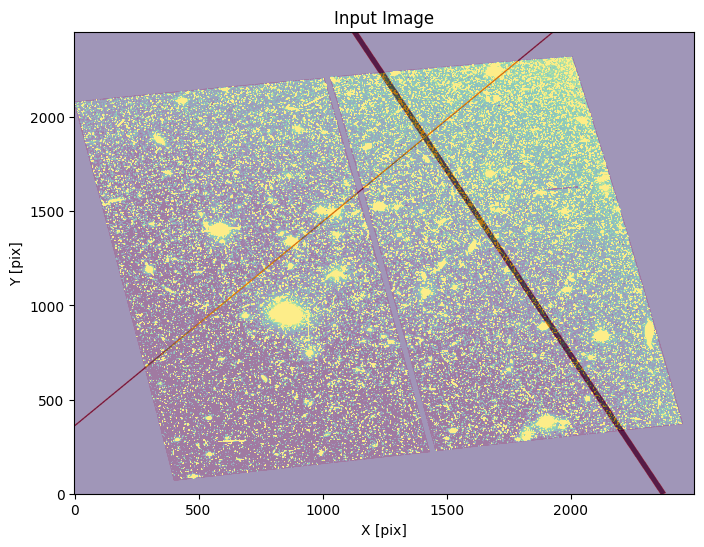

In [45]:
s4.plot_image(overlay_mask=True)

<a id="example5"></a>
## Example 5:  Finding trails in a DRC image using the WFC Wrapper

All of the setup from the last example can be streamlined using the `WfcWrapper` class.

In [46]:
w2 = WfcWrapper('hst_13498_32_acs_wfc_f606w_jc8m32j5_drc.fits', binsize=2, extension=1, processes=8,
                output_root='example5')

INFO:findsat_mrt:image type is drc
INFO:findsat_mrt:masking bad pixels
INFO:findsat_mrt:Subtracting median background
INFO:findsat_mrt:Rebinning the data by 2


Run full pipeline now

In [47]:
w2.run_all()

INFO:utils_findsat_mrt:Calculating median Radon Transform with 2 processes
INFO:findsat_mrt:Detection threshold: 5
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width15.fits
INFO:findsat_mrt:{no} sources found using kernel: 6
INFO:findsat_mrt:6 sources found using kernel
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width7.fits
INFO:findsat_mrt:{no} sources found using kernel: 9
INFO:findsat_mrt:9 sources found using kernel
INFO:findsat_mrt:Using kernel /opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/acstools/data/rt_line_kernel_width3.fits
INFO:findsat_mrt:{no} sources found using kernel: 19
INFO:findsat_mrt:19 sources found using kernel
INFO:findsat_mrt:Removing duplicate sources
INFO:findsat_mrt:20 final sources found
INFO:findsat_mrt:Filtering sources...
Min SNR : 5
Max Width: 75
Min Length: 25
Check persi

Let's plot the final mask to ensure it looks the same as the earlier examples.

<Axes: title={'center': 'Mask'}>

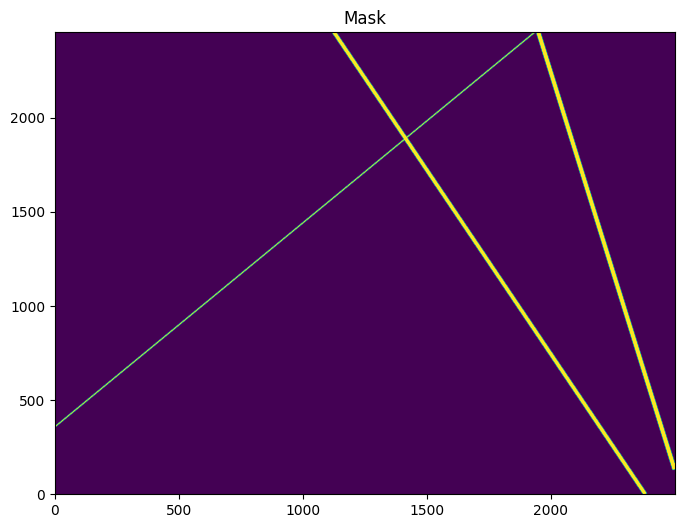

In [48]:
w2.plot_mask()

And there you go!

<a id="example6"></a>
## Example 6:  Create a new kernel for trail detection

We include a function called create_mrt_line_kernel that can be used to generate kernels for detecting trails of s specified size in the MRT. Note that kernels with widths of 1, 3, 7, and 15 pixels (convolved with a simple Gaussian HST/ACS psf model) are included already, but perhaps you want to generate a kernel with a new width, or convolved with a different PSF.

Let's generate a kernel for a trail that has an inherent width of 5 pixels and is convolved with a Gaussian PSF with `sigma=3`. 

INFO:utils_findsat_mrt:calculated endpoints: [(0, 511.5), (2047, 511.5)]
INFO:utils_findsat_mrt:Calculating median Radon Transform with 8 processes
INFO:utils_findsat_mrt:Inteprolating onto new grid to center kernel
/opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:593: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=13,24 m=175 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


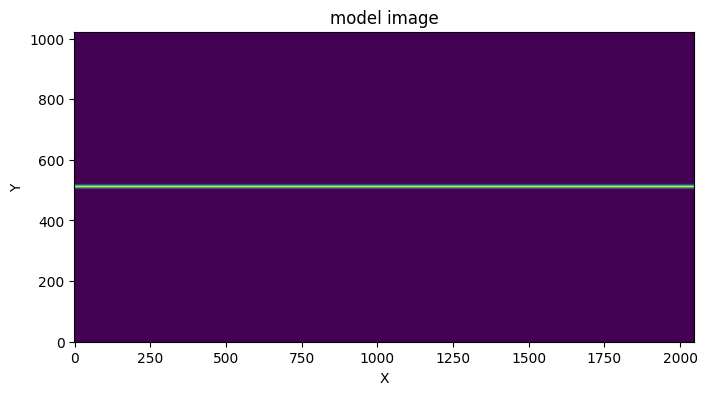

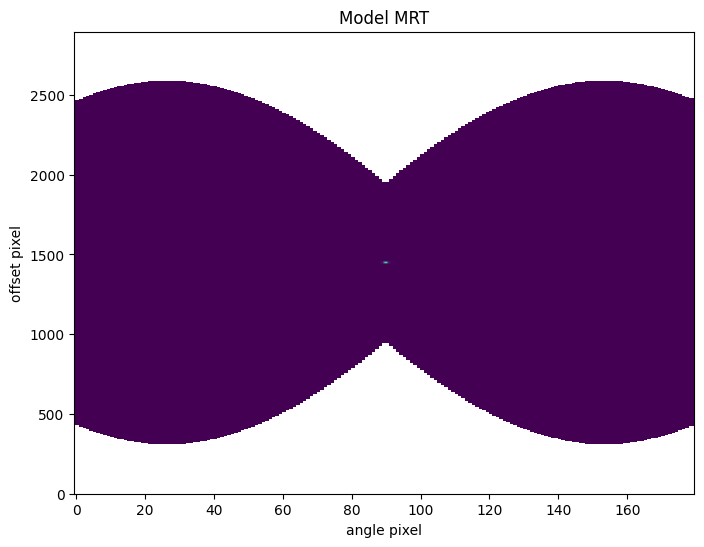

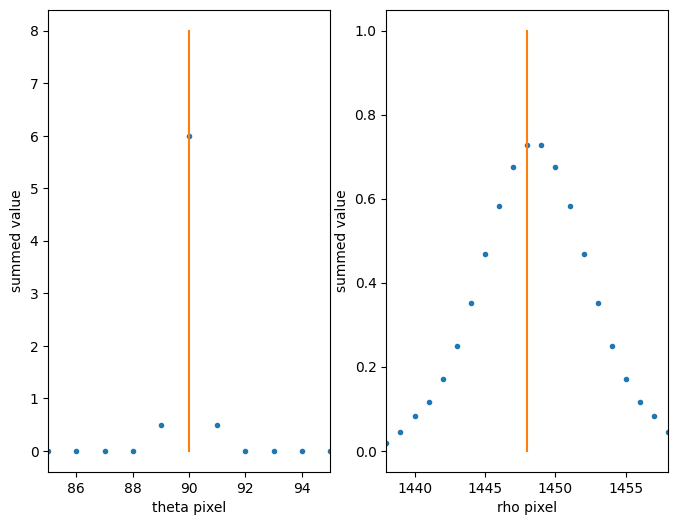

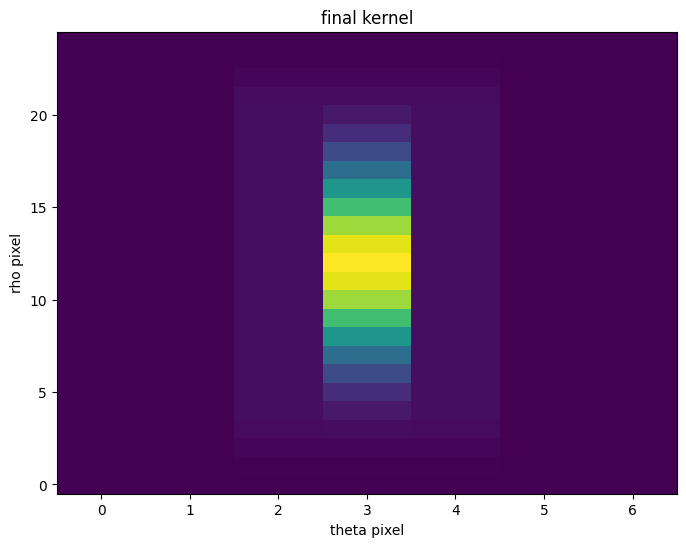

In [49]:
out = create_mrt_line_kernel(5, 3, processes=8, plot=True)

The first plot show the model streak. The second plot shows the resulting MRT. The kernsl is created by taking a cutout around the signal in the MRT. The third double-plot shows 1D slices of the signal in the MRT, with orange lines showing the location of the maximum values. These serve as first guesses of the center, after which the center is redetermined using a Guassian fit and the cutout extracted with the kernel perfectly centered. The 4th plot above shows the final kernel.

The kernel can be saved by defining the `outfile` keyword in `create_mrt_line_kernel`. By adding this file path into the `kernels` keyword in `TrailFinder` or `WfcWrapper`, it will be used for source detection when running `find_mrt_sources`.

### For more help:

More details may be found on the [ACS website](http://www.stsci.edu/hst/instrumentation/acs) and in the [ACS Instrument](https://hst-docs.stsci.edu/display/ACSIHB) and [Data Handbooks](http://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/acs/documentation/other-documents/_documents/acs_dhb.pdf).

Please visit the [HST Help Desk](http://hsthelp.stsci.edu). Through the help desk portal, you can explore the *HST* Knowledge Base and request additional help from experts.

---
[Top of Page](#titleFindsat)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 
<br></br>
<br></br>